In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, types, prange
import cmath
import PIL
from PIL import ImageFilter
from scipy.ndimage import gaussian_filter as gf

In [7]:
def circle_array(radius, size, freq = 10, plot=False):
    # We generate the grid for the circle function
    T = 1 / freq
    X, Y = np.meshgrid(np.arange(0, size, T), np.arange(0, size, T))
    center = size // 2
    dist = np.sqrt((X-center)**2 + (Y-center)**2)
    circle = (dist <= radius).astype(int)

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(circle, cmap='gray')
        
    return circle

In [33]:
def plot2d_ft(signal):
    ft = np.fft.fftshift(np.fft.fft2(signal))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log1p(np.abs(ft)), cmap='gray')

In [32]:
def plot2d_ft_func(signal):
    ft = np.fft.fftshift(np.fft.fft2(signal))
    freq_x = np.fft.fftshift(np.fft.fftfreq(signal.shape[1]))
    freq_y = np.fft.fftshift(np.fft.fftfreq(signal.shape[0]))
    fx_mesh, fy_mesh = np.meshgrid(freq_x, freq_y)

    # Creating the plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Adding the titles
    ax.set_xlabel('$f_x$')
    ax.set_ylabel('$f_y$')
    ax.set_zlabel('Magnitud')
    ax.set_title('Espectro de Potencia (Transformada de Fourier 2D)')
    
    ax.plot_surface(fx_mesh, fy_mesh, np.abs(ft), cmap='viridis')
    plt.show()

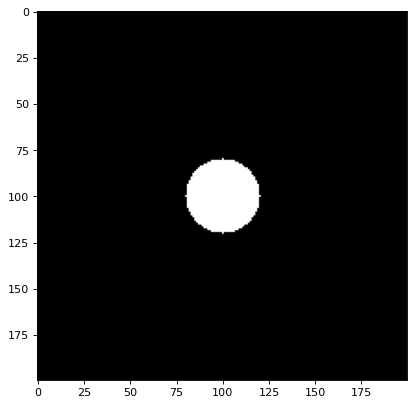

In [38]:
# We create the circ(r) function
radius = 1
size = 10 # Square where the circle is in
freq = 20 # For sampling of the circle

circ = circle_array(radius, size, freq, plot=True)

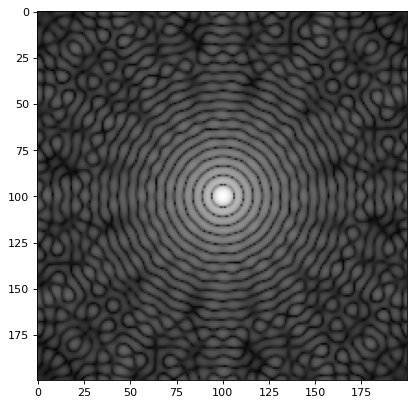

In [39]:
plot2d_ft(circ)

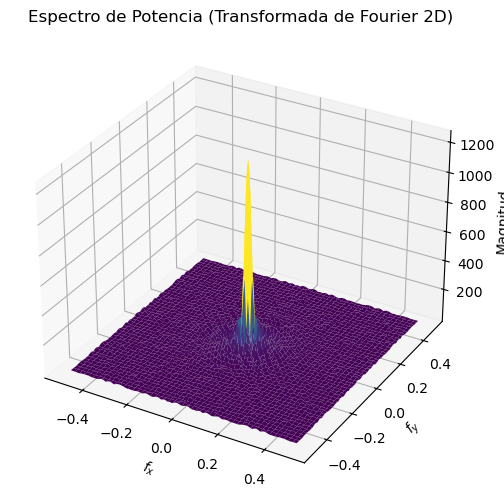

In [40]:
plot2d_ft_func(circ)

## Now we will proceed to program our own discrete fourier transform

In [13]:
# Since the 2D fourier transform is just multiple 1D fourier transforms, we will first implement that one.
@njit
def dft(signal):
    N = len(signal)
    output_signal = np.empty(N, dtype=np.complex128)

    for k in range(N):
        for n in range(N):
            kernel = cmath.exp(-2j * np.pi * k * n / N)
            output_signal[k] += signal[n] * kernel

    return output_signal

# Change the sign to have an inverse implementation
@njit
def dft(signal):
    N = len(signal)
    output_signal = np.empty(N, dtype=np.complex128)

    for k in range(N):
        for n in range(N):
            angle = 2 * np.pi * (k/N) * n
            output_signal[k] += signal[n] * (np.cos(angle) + np.sin(angle)*1j)

    return output_signal
            

In [ ]:
# Now let's try out the function

In [14]:
f = lambda x:  np.cos(2 * np.pi * x) 
freq = 10
T = 1/freq
domain = np.arange(-1, 1, T)
sig = f(domain)
ft = dft(sig)
ft

array([-5.32907052e-15+1.67048941e-51j, -7.32747196e-15-1.94289029e-16j,
        1.00000000e+01+1.05471187e-14j,  2.99760217e-15+7.77156117e-16j,
        1.41553436e-15+2.55351296e-15j,  1.00785528e-15+9.99200722e-16j,
        2.30371278e-15+2.22044605e-15j,  8.38218384e-15+7.77156117e-16j,
        2.22044605e-16+5.55111512e-17j, -3.55271368e-15+3.05311332e-15j,
        4.44089210e-16+5.61604241e-15j,  8.65973959e-15+1.08246745e-15j,
       -4.32986980e-15-1.49880108e-15j,  9.21485110e-15+2.22044605e-15j,
        3.66373598e-15+6.21724894e-15j,  1.06876885e-14+8.99280650e-15j,
        6.43929354e-15-3.33066907e-16j,  1.43218770e-14+6.66133815e-15j,
        1.00000000e+01-4.22439861e-14j, -1.80966353e-14+4.74620343e-15j])

### Now we will implement the 2D dft

In [55]:
@njit(parallel=True)
def dft2(image):
    M, N = image.shape
    output = np.zeros((M, N), dtype=np.complex128)
    for k in prange(M):
        for l in prange(N):
            sum = 0.0
            for m in range(M):
                temp_value = 0
                for n in prange(N):
                    kernel = cmath.exp(-2j * np.pi * ((k*m) / M + (l * n) /N))
                    temp_value += kernel * image[m, n]
                sum += temp_value
            output[k, l] = sum
    return output

@njit(parallel=True)
def inv_dft2(image):
    M, N = image.shape
    output = np.zeros((M, N), dtype=np.complex128)
    for k in prange(M):
        for l in prange(N):
            sum = 0.0
            for m in range(M):
                temp_value = 0
                for n in prange(N):
                    kernel = cmath.exp(2j * np.pi * ((k*m) / M + (l * n) /N))
                    temp_value += kernel * image[m, n]
                sum += temp_value
            output[k, l] = sum
    return output/np.sqrt(M*N)

### Subsampled functions

In [42]:
@njit(parallel=True)
def dft2_ss(image):
    M, N = image.shape
    output = np.zeros((M//2, N//2), dtype=np.complex128)
    for k in prange(M//2):
        for l in prange(N//2):
            sum = 0.0
            for m in range(0, M, 2):
                temp_value = 0
                for n in range(0, N, 2):
                    kernel = cmath.exp(-2j * np.pi * ((k*m) / M + (l * n) /N))
                    temp_value += kernel * image[m, n]
                sum += temp_value
            output[k, l] = sum
    return output

@njit(parallel=True)
def inv_dft2_ss(image):
    M, N = image.shape
    output = np.zeros((M//2, N//2), dtype=np.complex128)
    for k in prange(M//2):
        for l in prange(N//2):
            sum = 0.0
            for m in range(0, M, 2):
                temp_value = 0
                for n in range(0, N, 2):
                    kernel = cmath.exp(2j * np.pi * ((k*m) / M + (l * n) /N))
                    temp_value += kernel * image[m, n]
                sum += temp_value
            output[k, l] = sum
    return output

In [43]:
def dftshift(image):
    rows, cols = image.shape
    sh_img = np.empty_like(image)

    # Set the center
    y_split = rows // 2
    x_split = cols // 2

    #perform the shifting
    # Top left -> bottom right
    sh_img[:y_split, :x_split] = image[y_split:, x_split:]

    # Bottom right -> top left
    sh_img[y_split:, x_split:] = image[:y_split, :x_split]

    # Top right -> bottom left
    sh_img[:y_split, x_split:] = image[y_split:, :x_split]

    # Bottom left -> top right
    sh_img[y_split:, :x_split] = image[:y_split, x_split:]

    return sh_img

In [44]:
# Plot the function
def plot2d_dft(signal):
    #ft = np.fft.fftshift(dft2(signal))
    ft = dftshift(dft2(signal))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log1p(np.abs(ft)), cmap='gray') 
    return ft

def plot2d_dft_ss(signal):
    #ft = np.fft.fftshift(dft2(signal))
    ft = dftshift(dft2_ss(signal))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log1p(np.abs(ft)), cmap='gray') 
    return ft

def plot2d_inv_dft(signal):
    #ft = np.fft.fftshift(dft2(signal))
    ft = (inv_dft2(signal))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log1p(np.abs(ft)), cmap='gray') 
    return ft

def plot2d_inv_dft_ss(signal):
    #ft = np.fft.fftshift(dft2(signal))
    ft = (inv_dft2_ss(signal))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log1p(np.abs(ft)), cmap='gray') 
    return ft




In [45]:
def img_2_gray256(img_path, show = True):
    img = PIL.Image.open(img_path)
    img = img.convert("L")
    img256 = img.resize((256,256))
    img256 = np.squeeze(np.asarray(img256))
    if show:
        plt.imshow(img256, cmap='gray')

    return img256

In [46]:
def plot2d_both(img_path):
    #ft = np.fft.fftshift(dft2(signal))
    signal = img_2_gray256(img_path, show = False)
    ft = dftshift(dft2(signal))
    inv_ft = (inv_dft2(signal))
    plt.figure(num=None, figsize=(12, 6), dpi=80)
    plt.subplot(131), plt.imshow(signal, cmap='gray'), plt.title("Original") 
    plt.subplot(132), plt.imshow(np.log(np.abs(ft)), cmap='gray'), plt.title("DFT") 
    plt.subplot(133), plt.imshow(np.log(np.abs(ft)), cmap='gray'), plt.title("Inverse DFT") 
    return ft

In [47]:
def gaussian_filter(img_path, radius, show = True):
    img = PIL.Image.open(img_path)
    img = img.convert("L")
    img256 = img.resize((256,256))
    img256 = img256.filter(ImageFilter.GaussianBlur(radius=radius))
    img256 = np.squeeze(np.asarray(img256))
    if show:
        img256 = np.squeeze(np.asarray(img256))
    
    plt.imshow(img256, cmap='gray')

    return img256


def plot2d_both_gauss(img_path, radius):
    #ft = np.fft.fftshift(dft2(signal))
    signal = gaussian_filter(img_path, radius, show = False)
    ft = dftshift(dft2(signal))
    inv_ft = (inv_dft2(signal))
    plt.figure(num=None, figsize=(16, 6), dpi=80)
    plt.subplot(131), plt.imshow(signal, cmap='gray'), plt.title("Original") 
    plt.subplot(132), plt.imshow(np.log(np.abs(ft)), cmap='gray'), plt.title("DFT") 
    plt.subplot(133), plt.imshow(np.log(np.abs(inv_ft)), cmap='gray'), plt.title("Inverse DFT") 
    return ft

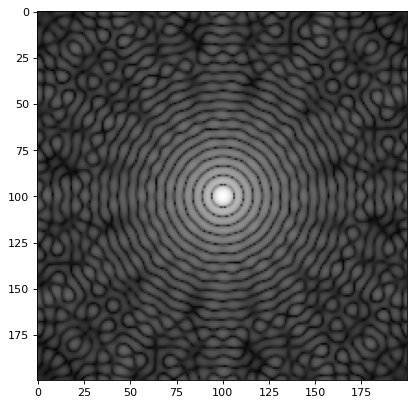

In [48]:
sinc = plot2d_dft(circ)

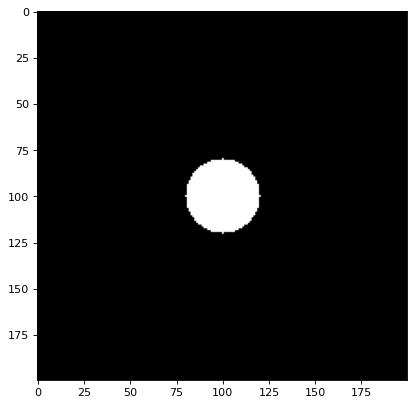

In [49]:
circle = plot2d_inv_dft(sinc)

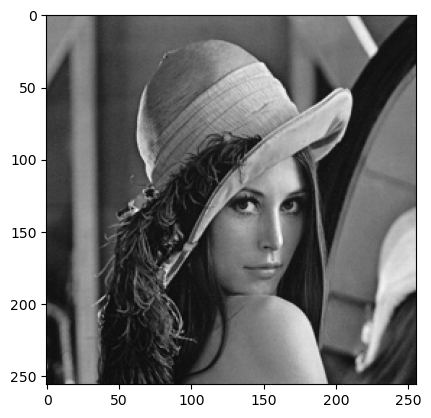

In [51]:
lenna = img_2_gray256("lenna.jpg")

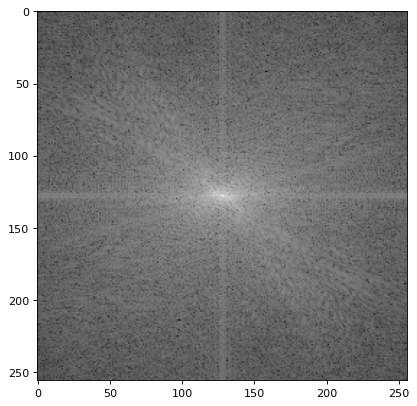

In [52]:
dft = plot2d_dft(lenna) 

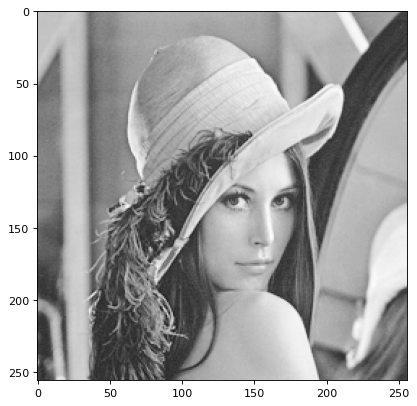

In [53]:
inv_dtf = plot2d_inv_dft(dft)

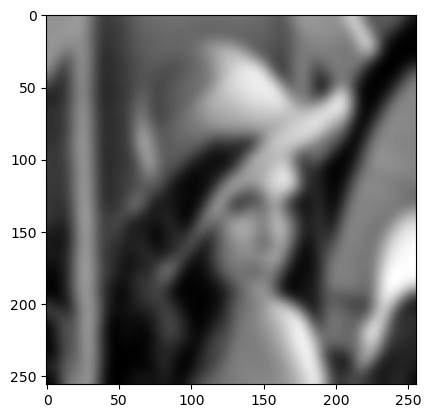

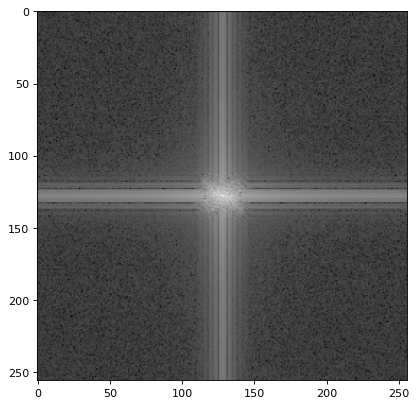

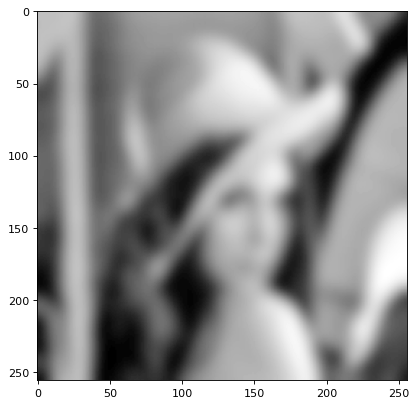

In [56]:
lenna = img_2_gray256("lenna.jpg")
lenna_gauss = gaussian_filter("lenna.jpg", 5)
dft_lenna = plot2d_dft(lenna_gauss)
inv_dtf = plot2d_inv_dft(dft_lenna)

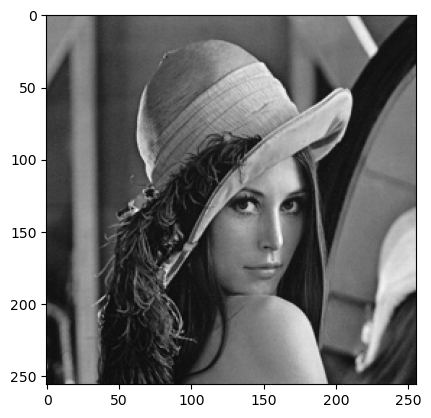

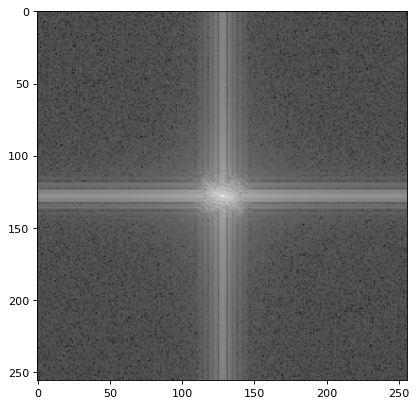

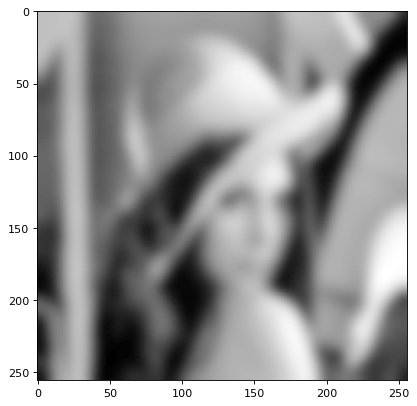

In [30]:
lenna = img_2_gray256("lenna.jpg")
dft_lenna = plot2d_dft(gf(lenna, sigma=5))
inv_dtf_lenna = plot2d_inv_dft(dft_lenna)

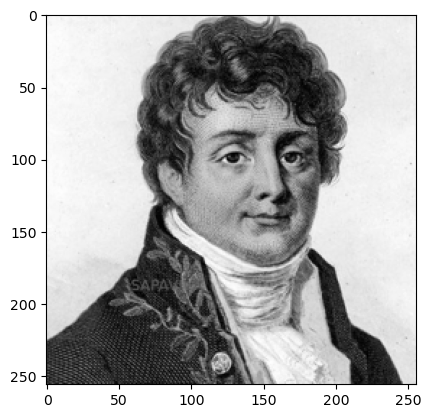

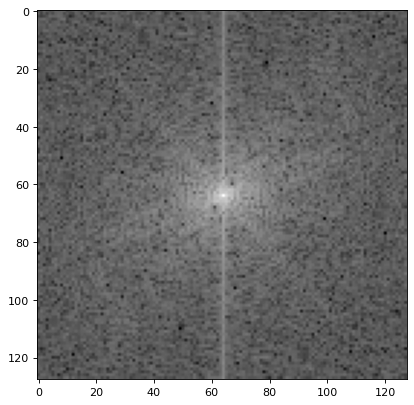

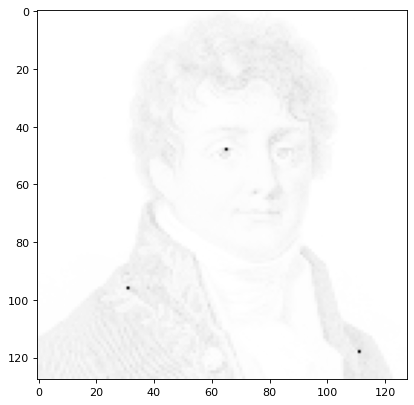

In [45]:
fourier = img_2_gray256("fourier.jpg")
dft_fourier_ss = plot2d_dft_ss(fourier)
inv_dtf_fourier = plot2d_inv_dft(dft_fourier_ss)

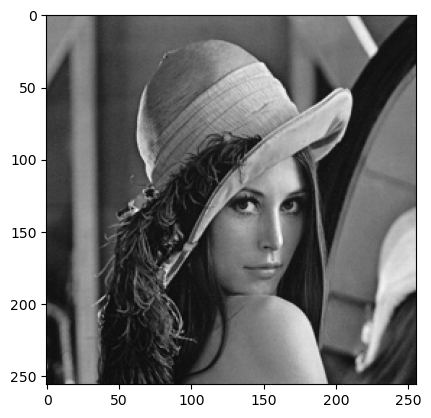

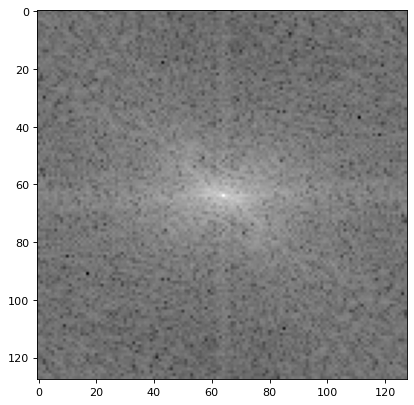

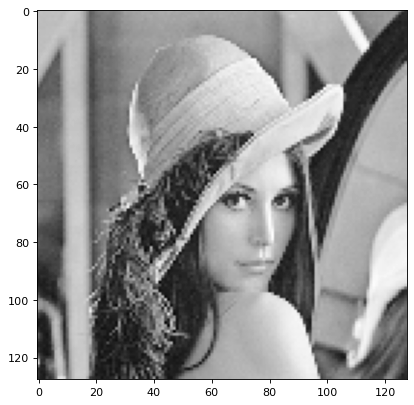

In [46]:
lenna = img_2_gray256("lenna.jpg")
dft_lenna_ss = plot2d_dft_ss(lenna)
inv_dtf_fourier = plot2d_inv_dft(dft_lenna_ss)

ValueError: cannot reshape array of size 65536 into shape (128,128)

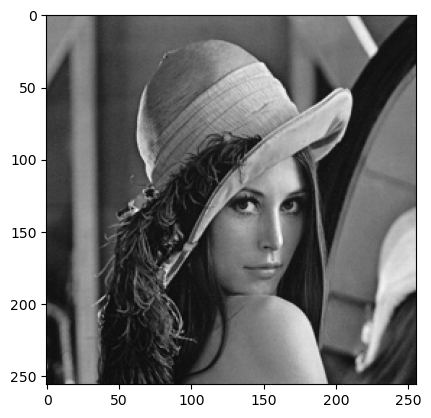

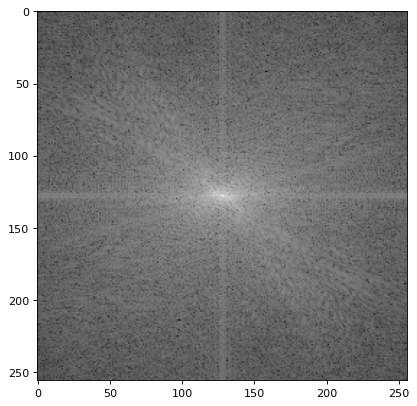

In [63]:
lenna = img_2_gray256("lenna.jpg")
dft_lenna = plot2d_dft(lenna)
dft_lenna  = dft_lenna.reshape(128,128)
inv_dtf_lenna_ss = plot2d_inv_dft(dft_lenna)

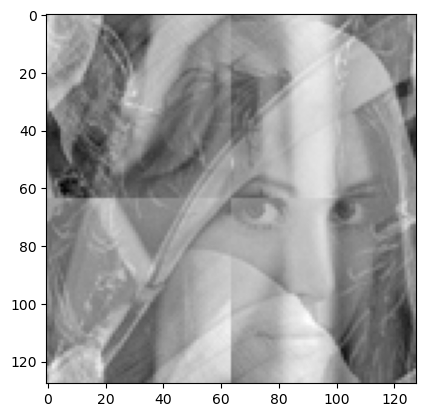

In [53]:
plt.imshow(dftshift(np.log(np.abs(inv_dtf_lenna_ss))), cmap="grey")